### Author - Sidhanta Narayan Singhdeo

### CWID  - 10465272
### Course - AAI 800 (Special Problems in AI)
### Project Advisor - Prof. Hong Man

## FL Model Build

* The FL Architecture implemented below on the TFF frameework to perfom Image recognition on the CIFAR100 dataset.
* The CIFAR 100 data is preprocessd and transformed to work with TFF framework
* We make use of standard function available in TFF to perform the federated Learning.


In [32]:
#Patch asyncio to allow nested event loops
import nest_asyncio
nest_asyncio.apply()

In [33]:
#Load required Libraries
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import functools
import collections


In [34]:
# Load Keras models 
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [35]:
# Deactivates GPU execution, to tun on GPU set to [0,1,2..] depending on number of GPUs
# Switched to CPU as GPU was giving errors due to limited memory
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [36]:
# check GPUis switched off
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
  print('Cannot detect physical GPU device in TF')
# tf.config.set_logical_device_configuration(
#     gpu_devices[0], 
#     [tf.config.LogicalDeviceConfiguration(memory_limit=5120),
#      tf.config.LogicalDeviceConfiguration(memory_limit=5120)])
# tf.config.list_logical_devices()

Cannot detect physical GPU device in TF


In [37]:
# Check TFF computation is running correctly
def hello_world():
  return 'Hello, World!'

hello_world()


'Hello, World!'

# Input Section
Select values for parameters 

In [38]:
default_number_of_clients = 20
NUMBER_OF_CLIENTS = int(input("Enter Number of Clients: ") or default_number_of_clients)

default_number_of_rounds = 10
NUMBER_OF_ROUNDS = int(input("Enter Number of Rounds: ") or default_number_of_rounds )

default_client_dataset_size = 500
MAX_CLIENT_DATASET_SIZE = int(input("Enter Max Client Datset Size: ") or default_client_dataset_size)

default_client_epochs_per_round = 1
CLIENT_EPOCHS_PER_ROUND = int(input("Enter Client Epochs pe round: ") or default_client_epochs_per_round)

default_client_batch_size = 20
CLIENT_BATCH_SIZE = int(input("Enter Client Batch Size: ") or default_client_batch_size)

default_client_test_batch_size = 100
TEST_BATCH_SIZE = int(input("Enter Test Batch Size: ") or default_client_test_batch_size)




In [39]:
hyperparameters = str(NUMBER_OF_CLIENTS)+'/'+str(NUMBER_OF_ROUNDS)+'/'+str(MAX_CLIENT_DATASET_SIZE)+'/'+str(CLIENT_EPOCHS_PER_ROUND)+'/'+str(CLIENT_BATCH_SIZE)
hyperparameters

'20/10/500/1/20'

# Load CIFAR 100 Data 
The simulation Datasets have predefined clients which are subsets of the whole dataset
No need to create seperate clients data

In [40]:
cifar_train, cifar_test = tff.simulation.datasets.cifar100.load_data()

In [41]:
# Check Data type
cifar_train.element_type_structure


OrderedDict([('coarse_label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('image',
              TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)),
             ('label', TensorSpec(shape=(), dtype=tf.int64, name=None))])

In [42]:
#Check Length
len(cifar_train.client_ids)

500

In [43]:
example_dataset = cifar_train.create_tf_dataset_for_client(cifar_train.client_ids[0])
example_element= next(iter(example_dataset))


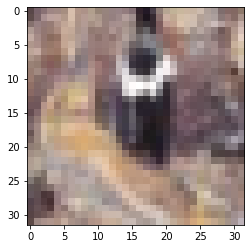

In [44]:

#Plot sample Image
from matplotlib import pyplot as plt
plt.figure(figsize=(15,4))
plt.imshow(example_element['image'].numpy(), cmap='gray',aspect='equal')  
plt.grid(False)
_ = plt.show()

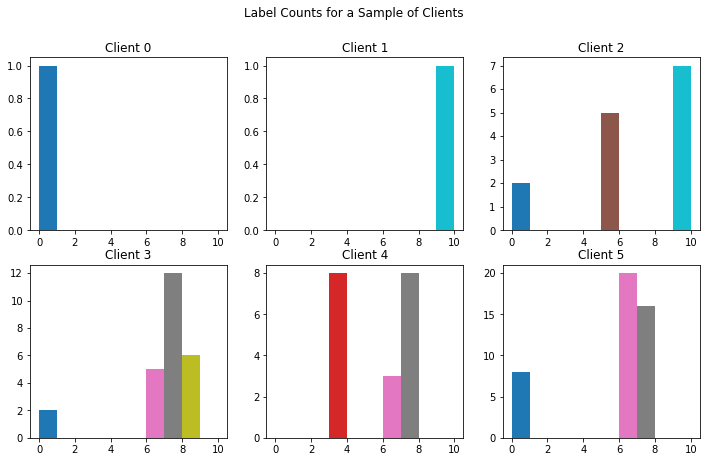

In [45]:
# Check distribution of Data classes among the 6 Clients 
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = cifar_train.create_tf_dataset_for_client(
      cifar_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Start Preprocessing the Data

In [46]:
#reshape to use with keras model
def reshape_cifar_element(element):
  return (tf.cast(tf.reshape(element['image'], [-1,32,32,3]),dtype=tf.float64), tf.reshape(element['coarse_label'],[-1,1]))
        

In [47]:
# Build Federated preprocessing that will drive the client training
# load from the Inputted parameters 
def preprocess_train_dataset(dataset):
  return (dataset
          .shuffle(buffer_size=MAX_CLIENT_DATASET_SIZE)
          .repeat(CLIENT_EPOCHS_PER_ROUND)
          .batch(CLIENT_BATCH_SIZE, drop_remainder=False)
          .map(reshape_cifar_element))

In [48]:
# Preprocess train data.
federated_train_data= cifar_train.preprocess(preprocess_train_dataset)

## Keras Model Declaration

In [49]:
def create_original_fedavg_cnn_model(cache_dir=None):
    # data_format = 'channels_last'
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3),data_format='channels_last'))
    model.add(LeakyReLU(alpha=0.1))
    BatchNormalization(axis=-1)
    model.add(Conv2D(32, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    BatchNormalization(axis=-1)
    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    BatchNormalization(axis=-1)
    model.add(Conv2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    BatchNormalization()
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    BatchNormalization()
    model.add(Dropout(0.2))
    model.add(Dense(100))


    model.add(Activation('softmax'))
    model.summary()
    return model

In [50]:
# Specify Input Spec for configuring shape of input data to TFF wrapper function 
input_spec = federated_train_data.create_tf_dataset_for_client(
    federated_train_data.client_ids[0]).element_spec
input_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))

In [51]:
# Wrap the keras Model to be used in TFF
def tff_model_fn():
  keras_model = create_original_fedavg_cnn_model()
  return tff.learning.from_keras_model(
      keras_model=keras_model,
      input_spec=input_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [52]:
# training the model 
federated_averaging = tff.learning.build_federated_averaging_process(
    model_fn=tff_model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 64)        0

In [53]:
#Monitor Data transfer
#High transfer rates crash the CPU/GPU leading o erraneous results and processing skips 
def format_size(size):
  size = float(size)
  for unit in ['bit','Kibit','Mibit','Gibit']:
    if size < 1024.0:
      return "{size:3.2f}{unit}".format(size=size, unit=unit)
    size /= 1024.0
  return "{size:.2f}{unit}".format(size=size, unit='TiB')

In [54]:
def set_sizing_environment():
  sizing_factory = tff.framework.sizing_executor_factory()
  context = tff.framework.ExecutionContext(executor_fn=sizing_factory)
  tff.framework.set_default_context(context)

  return sizing_factory

In [55]:
# Clean the log directory to avoid conflicts.
# Set up Tensorboard
import os 
import shutil
import datetime
run_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
hp = str
logdir = r"C:\Users\sidha\Stevens\AAI800 - Special Projects in AI\Project Execution\Tensorboard\TF-CNN2" + run_time + hyperparameters
if os.path.exists(logdir):
    shutil.rmtree(logdir)

summary_writer = tf.summary.create_file_writer(logdir)


In [56]:
# Build training function to iterate over Fed Data
def train(federated_averaging_process, num_rounds, num_clients_per_round, summary_writer):
  environment = set_sizing_environment()

  # Initialize the Federated Averaging algorithm to get the initial server state.
  state = federated_averaging_process.initialize()

  with summary_writer.as_default():
    for round_num in range(num_rounds):
      # Sample the clients parcitipated in this round.
      sampled_clients = np.random.choice(
          federated_train_data.client_ids,
          size=num_clients_per_round,
          replace=False)
      # Create a list of `tf.Dataset` instances from the data of sampled clients.
      sampled_train_data = [
          federated_train_data.create_tf_dataset_for_client(client)
          for client in sampled_clients
      ]
      state, metrics = federated_averaging_process.next(state, sampled_train_data)

      size_info = environment.get_size_info()
      broadcasted_bits = size_info.broadcast_bits[-1]
      aggregated_bits = size_info.aggregate_bits[-1]

      print('round {:2d}, metrics={}, broadcasted_bits={}, aggregated_bits={}'.format(round_num, metrics, format_size(broadcasted_bits), format_size(aggregated_bits)))

      # Add metrics to Tensorboard.
      for name, value in metrics['train'].items():
          tf.summary.scalar(name, value, step=round_num)

      # Add broadcasted and aggregated data size to Tensorboard.
      tf.summary.scalar('cumulative_broadcasted_bits', broadcasted_bits, step=round_num)
      tf.summary.scalar('cumulative_aggregated_bits', aggregated_bits, step=round_num)
      summary_writer.flush()
  return state

In [57]:
# Execute Iterative training preocees and Get Final state and metrics
final_state=train(federated_averaging_process=federated_averaging, num_rounds=NUMBER_OF_ROUNDS,
      num_clients_per_round=NUMBER_OF_CLIENTS, summary_writer=summary_writer)

round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.253), ('loss', 9.553589)]))]), broadcasted_bits=571.64Mibit, aggregated_bits=571.65Mibit
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2935), ('loss', 10.988785)]))]), broadcasted_bits=1.12Gibit, aggregated_bits=1.12Gibit
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.262), ('loss', 11.703824)]))]), broadcasted_bits=1.67Gibit, aggregated_bits=1.67Gibit
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDi

In [58]:
#Perform Model Evaluation
evaluation = tff.learning.build_federated_evaluation(tff_model_fn)
print(evaluation.type_signature.formatted_representation())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 64)        0

In [59]:
#Pull final Model weights from final state 
model_weights = tff.learning.ModelWeights(trainable=final_state.model,non_trainable=final_state.model)

In [60]:
# Not necessary 
# Use below code to perform test data evaluation

# federated_test_data = cifar_test.preprocess(preprocess_train_dataset)
# # federated=tf.map_fn(reshape_cifar_element, example_dataset)
# for round_num in range(10):
#       # Sample the clients parcitipated in this round.
#       sampled_clients = np.random.choice(
#           federated_test_data.client_ids,
#           size=TEST_BATCH_SIZE,
#           replace=False)
#       # Create a list of `tf.Dataset` instances from the data of sampled clients.
#       sampled_train_data = [
#           federated_test_data.create_tf_dataset_for_client(client)
#           for client in sampled_clients
#       ]
#       test_metrics = evaluation(final_state.model, sampled_train_data)
#       test_metrics

In [61]:
# test_metrics